In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time

from moist_euler_dg.fortran_three_phase_euler_2D import FortranThreePhaseEuler2D

In [2]:
# test case parameters
domain_width = 10_000 # width of domain in metres
domain_height = 10_000 # height of domain in metres

p_surface = 1_00_000.0 # surface pressure in Pa
T_surface = 300 # surface temperature in Kelvin

perturbation = 2.0 # controls strength of bubble

In [3]:
# model parameters
nz = 32 # number of cells in vertical direction
nx = 32 # number of cells in horizontal direction
polynomial_order = 3 # order or polynomials in each cell


# note: horizontal resolution dx = width / (nx * polynomial_order),
# vertical resolution dz = height / (nz * polynomial_order)

# other parameters that probably don't need to be changed
g = 9.81 # gravitational acceleration
upwind = True # whether to use upwind fluxes for moisture and entropy transport
a = 0.5 # kinetic energy dissipation parameter
cfl = 0.5 # sets the CFL number of the time step, dt = CFL * speed of sound / min(dx, dz)

Model time: 0
Model x-coords: shape: (32, 32, 4, 4)
Model z-coords shape: (32, 32, 4, 4)
Model temperature shape: (32, 32, 4, 4)


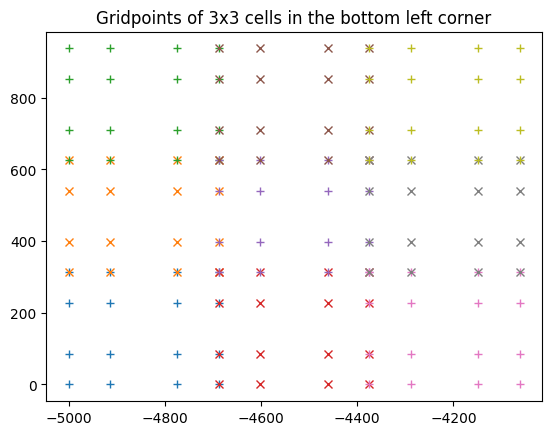

In [4]:
# construct solver
# maps [0, 1]^2 to domain - can be used to create curved meshes
# this just creates a rectangular grid
zmap = lambda x, z: z * domain_height
xmap = lambda x, z: domain_width * (x - 0.5)

# create a really small examples solver with 2 horixzontal cells and 3 vertical cells
solver = FortranThreePhaseEuler2D(
    xmap, zmap, polynomial_order, nx=nx, nz=nz, g=9.81, cfl=0.5, a=0.5, upwind=upwind
)
# the solver contains the model time, the x and z coordinates of each grid points, 
# and the model state (density, temperature, etc. defined at each grid point)

# all data is stored in numpy arrays with the shape (nx, nz, order+1, order+1)
print('Model time:', solver.time)
print('Model x-coords: shape:', solver.xs.shape)
print('Model z-coords shape:', solver.xs.shape)
print('Model temperature shape:', solver.T.shape)

# plot of  gird points in the bottom left 3x3 cells
# color and symbols alternate by cell
# notice that at the double up of points at the element boundaries

plt.title("Gridpoints of 3x3 cells in the bottom left corner")
symbol = 'x'
for i in range(3):
    for j in range(3):
        if symbol == 'x':
            symbol = "+"
        else:
            symbol = 'x'
        plt.plot(solver.xs[i, j].ravel(), solver.zs[i, j].ravel(), symbol)
plt.show()

### Solver variables

- T: temperature
- p: pressure
- s: specific entropy
- h: density
- q/qw: water mass fraction
- qv: water vapour mass fraction
- ql: liquid water mass fraction
- qi: ice mass fraction
- u: horizontal air velocity
- w: vertical air velocity

In [5]:
def neutrally_stable_dry_profile(solver):
    # create a hydrostatically balanced pressure and density profile
    dexdy = -g / (solver.cpd * T_surface)
    ex = 1 + dexdy * solver.zs
    p = p_surface * ex ** (solver.cpd / solver.Rd)
    density = p / (solver.Rd * ex * T_surface)
    
    return density, p

    

def initial_condition(solver, perturbation):
    # initial wind is zero
    u = np.zeros_like(solver.xs)
    w = np.zeros_like(solver.xs)
    
    density, p = neutrally_stable_dry_profile(solver)
    
    # add arbitrary moisute profile
    qw = solver.rh_to_qw(0.95, p, density) # choose 95% relative humidity
    
    # add perturbation/bubble to profile
    # increase entropy
    bubble_radius = 2_000
    distance = np.sqrt(solver.xs ** 2 + (solver.zs - 1.0 * bubble_radius) ** 2)
    bubble = np.cos(np.pi * (distance / bubble_radius) / 2) ** 2
    density -= (perturbation * density / 300) * bubble * (distance < bubble_radius)
    
    # model must be initialized with entropy not temperature
    # so convert density, pressure, qw profile to a density, entropy, qw profile
    s = solver.entropy(density, qw, p=p)
    
    # can also do s = solver.entropy(density, qw, T=T) to use temperature profiles
    
    return u, w, density, s, qw

In [6]:
# intialize solver
u, w, density, s, qw = initial_condition(solver, perturbation)
solver.time = 0
solver.set_initial_condition(u, w, density, s, qw)

In [7]:
# inspecting variables
print('Temperature range:', solver.T.min(), solver.T.max())
print('Pressure range:', solver.p.min(), solver.p.max())
print('Density range:', solver.h.min(), solver.h.max())
print('Entropy range:', solver.s.min(), solver.s.max())
print('Water fraction range:', solver.q.min(), solver.q.max())
print('Water vapour fraction range:', solver.qv.min(), solver.qv.max())
print('Liquid water fraction range:', solver.ql.min(), solver.ql.max())

Temperature range: 202.28993073581225 298.5080684518852
Pressure range: 25193.61612123405 99999.99999999997
Density range: 0.43394271347629176 1.1614401858304297
Entropy range: 2422.4797180648284 2498.9385116010667
Water fraction range: 7.386642278473904e-06 0.008243762506076892
Water vapour fraction range: 7.386642278473904e-06 0.008243762506076892
Liquid water fraction range: 0.0 0.0


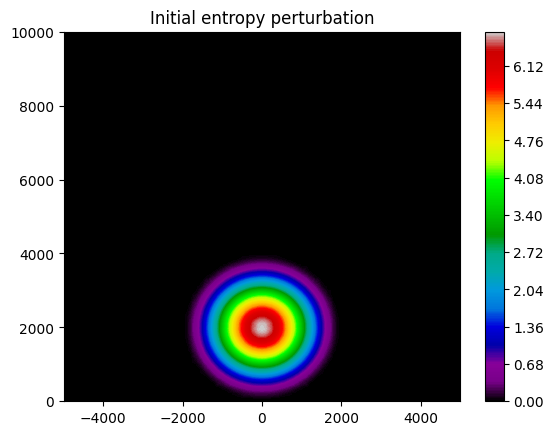

In [8]:
# plotting
# get bubble free profile to plot perturbation
_, _, density0, s0, qw0 = initial_condition(solver, 0)
plt.title('Initial entropy perturbation')
plt.tricontourf(
    solver.xs.ravel(), solver.zs.ravel(), solver.s.ravel() - s0.ravel(), levels=1000, cmap='nipy_spectral'
)
plt.colorbar()
plt.show()

Wall time: 49.30465316772461s
Model time: 600.0374482671227s


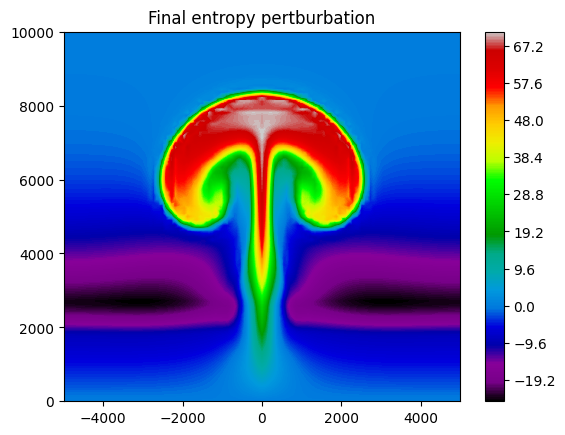

In [9]:
# run the simulation!
tend = 600 # simulation end time in seconds
t0 = time.time()
while solver.time < tend:
    solver.time_step()
 
t1 = time.time()
print(f'Wall time: {t1 - t0}s')
print(f'Model time: {solver.time}s')
_, _, density0, s0, qw0 = initial_condition(solver, 0)
plt.title('Final entropy pertburbation')
plt.tricontourf(
    solver.xs.ravel(), solver.zs.ravel(), solver.project_H1(solver.s).ravel() - s0.ravel(), levels=1000, cmap='nipy_spectral'
)
plt.colorbar()
plt.show()

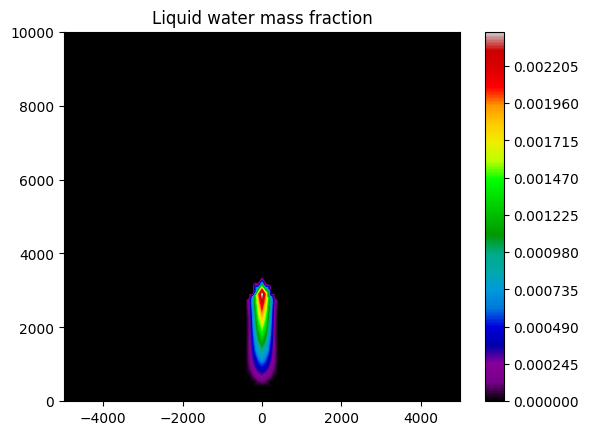

In [10]:
_, _, density0, s0, qw0 = initial_condition(solver, 0)
plt.title('Liquid water mass fraction')
plt.tricontourf(
    solver.xs.ravel(), solver.zs.ravel(), solver.project_H1(solver.ql).ravel(), levels=1000, cmap='nipy_spectral'
)
plt.colorbar()
plt.show()

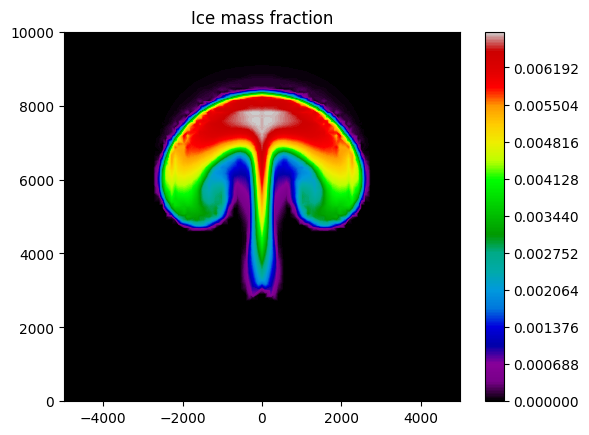

In [11]:
_, _, density0, s0, qw0 = initial_condition(solver, 0)
plt.title('Ice mass fraction')
plt.tricontourf(
    solver.xs.ravel(), solver.zs.ravel(), solver.project_H1(solver.qi).ravel(), levels=1000, cmap='nipy_spectral'
)
plt.colorbar()
plt.show()